# Properly Sized Color Bars for `imshow()` Plots in Matplotlib

[back to overview page](index.ipynb)

By default, the size of color bars is computed to match the figure size.
However, in most cases I have seen, it would be more appropriate to scale the color bars to match the size of the actual plot.

If you want to skip all the boring explanations, you can jump right to [the solution](#The-Proper-Solution).

You can also have a look at [my stackoverflow answer on the topic](http://stackoverflow.com/a/33505522/).

As always, the information on this page might be outdated:

In [1]:
!date +%F

2024-09-15


This is the date of the last change to this page. If it's older then half a year or a year, it is very likely to be outdated, so don't read it!

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
plt.rcParams['image.cmap'] = 'coolwarm'
plt.rcParams['image.origin'] = 'lower'

Please check if your local settings for the "inline" backend are meaningful, see [Default Values for Matplotlib's "inline" backend](matplotlib-inline-defaults.ipynb).

Some [dummy data](http://matplotlib.org/examples/pylab_examples/pcolor_demo.html):

In [4]:
def dummy_data(xmin, xmax):
    ymin, ymax = -2, 2
    x, y = np.meshgrid(np.arange(xmin, xmax, 0.1), np.arange(ymin, ymax, 0.1))
    z = (1 - x / 2 + x ** 5 + y ** 3) * np.exp(-x ** 2 - y ** 2)
    extent = x.min(), x.max(), y.min(), y.max()
    return z, extent

In [5]:
z, extent = dummy_data(-3, 3)
zmax = np.max(np.abs(z))

## The Problem

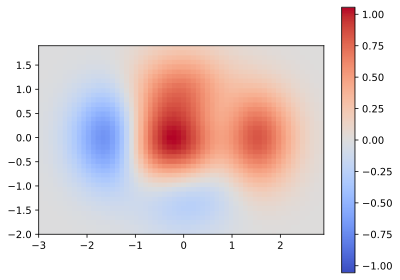

In [6]:
fig, ax = plt.subplots()
im = ax.imshow(z, extent=extent, vmin=-zmax, vmax=zmax)
fig.colorbar(im);

Obviously, the color bar is too tall.

If this doesn't bother you, stop reading.

## "Solution" 1: Fiddling with the Figure Size

Since the figure seems to be too high for its width, let's just make it a little lower:

In [7]:
plt.rcParams['figure.figsize']

[6.4, 4.8]

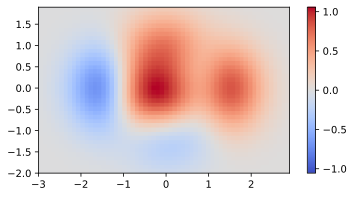

In [8]:
fig, ax = plt.subplots(figsize=(6.4, 3))
im = ax.imshow(z, extent=extent, vmin=-zmax, vmax=zmax)
fig.colorbar(im);

This works, but it's not a general solution.
Whenever you have a different data size, you'll have to fiddle with the figure size.

## Aside: Color Bar Aspect Ratio

By default, a color bar has an aspect ratio of 20, i.e. its height is 20 times its width (in the case of a vertical color bar).

If you want it wider or narrower, you have to choose a lower or higher value, respectively.
To get twice the width as before, let's use an aspect ratio of 10.

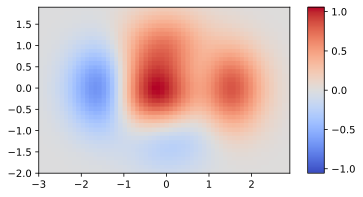

In [9]:
fig, ax = plt.subplots(figsize=(6.4, 3))
im = ax.imshow(z, extent=extent, vmin=-zmax, vmax=zmax)
fig.colorbar(im, aspect=10);

## Aside: Distance between Plot and Color Bar

If you don't like the amount of space between the color bar and the actual plot (the default hardly ever looks nice), you can use the `pad` parameter:

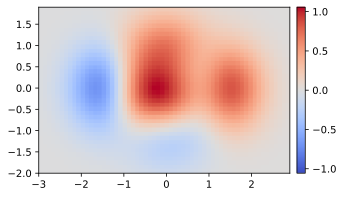

In [10]:
fig, ax = plt.subplots(figsize=(6.4, 3))
im = ax.imshow(z, extent=extent, vmin=-zmax, vmax=zmax)
fig.colorbar(im, pad=0.02);

The value of `pad` is given as relative width of the plot (between 0.0 and 1.0).
See below for how to use a more meaningful quantity.

## "Solution" 2: Fiddling with `shrink`

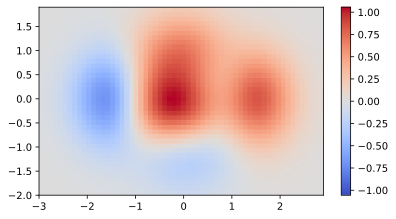

In [11]:
fig, ax = plt.subplots()
im = ax.imshow(z, extent=extent, vmin=-zmax, vmax=zmax)
fig.colorbar(im, shrink=0.71);

## "Solution" 3: Fiddling with Manual Placement

* using `fig.add_axes()`

* using GridSpec: http://worksofscience.net/matplotlib/colorbar

* using ImageGrid: http://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html#imagegrid

The details are left as an exercise for the reader.
Spoiler alert: It will be fiddly!

## Official "Solution" from the Matplotlib Documentation: `axes_grid1`

In all of the above "solutions", we had to fiddle with some parameters. And whenever the data size changed, we had to do it all over again.

But the official matplotlib documentation shows a way how to get the height right without fiddling:
https://matplotlib.org/stable/gallery/axes_grid1/demo_colorbar_with_axes_divider.html.

Sadly, this is quite complicated.
And, as we'll see, it only avoids a part of the fiddling ...

In [12]:
from mpl_toolkits import axes_grid1

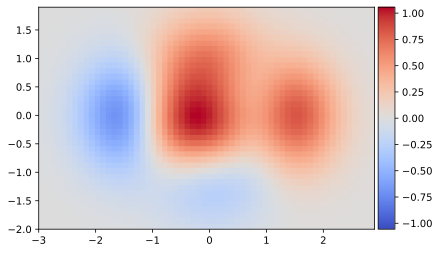

In [13]:
fig, ax = plt.subplots()
im = ax.imshow(z, extent=extent, vmin=-zmax, vmax=zmax)
divider = axes_grid1.make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax);

This is better than the previous "solutions", because the color bar will now have the correct height, regardless of the plot width.

However, although the height is correct, the width is given relative to the width of the image plot.
This means that if we change the width of our plot, the width of the color bar will change, too.

In [14]:
narrow_z, narrow_extent = dummy_data(-2, 0)

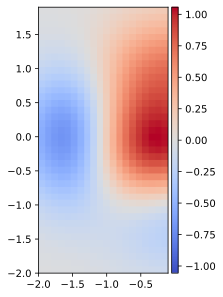

In [15]:
fig, ax = plt.subplots()
im = ax.imshow(narrow_z, extent=narrow_extent, vmin=-zmax, vmax=zmax)
divider = axes_grid1.make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax);

To get the width we want, we still have to do some fiddling with the `size` parameter.

## The Proper Solution

The mysterious `axes_grid1` module looked promising, but we'll have to try a little harder.

This stuff is getting more and more complicated, so I'm putting it into a little helper function:

In [16]:
from mpl_toolkits import axes_grid1

def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes('right', size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

Note that you only have to pass the image object which you get from `imshow()`, the containing `Axes` and `Figure` objects are obtained automatically.

Further, you should note that `append_axes()` updates matplotlib's internal [current axes object](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.gca).
This might not be what you expect, especially if you want to add something like axis labels afterwards.
Therefore, the function restores the current axes object from before the call to `append_axes()`.

OK, let's see how this works on the narrow plot from above:

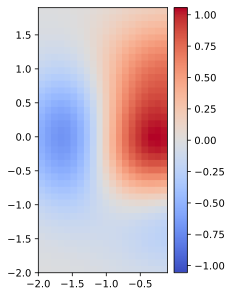

In [17]:
fig, ax = plt.subplots()
im = ax.imshow(narrow_z, extent=narrow_extent, vmin=-zmax, vmax=zmax)
add_colorbar(im);

Good. Now the wide plot:

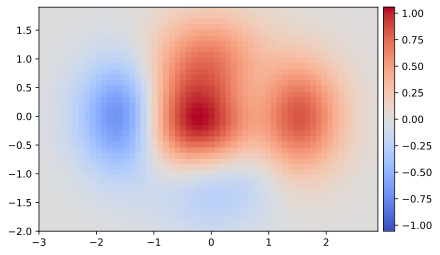

In [18]:
fig, ax = plt.subplots()
im = ax.imshow(z, extent=extent, vmin=-zmax, vmax=zmax)
add_colorbar(im);

Very nice! Now the color bar looks the same in both cases, just as I like it.

And there was no fiddling involved at all (but I admit that the code looks a bit frightening).

The aspect ratio and the space between color bar and plot can still be tweaked, if desired:

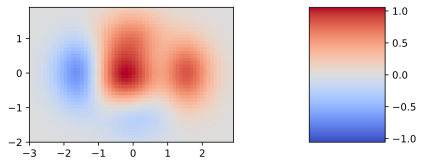

In [19]:
fig, ax = plt.subplots()
im = ax.imshow(z, extent=extent, vmin=-zmax, vmax=zmax)
add_colorbar(im, aspect=16/9, pad_fraction=1);

I'm not saying that this looks nice, but it should illustrate how to use the `aspect` and `pad_fraction` parameters.

## Does This Work with Subplots?

I guess ... let's try, shall we?

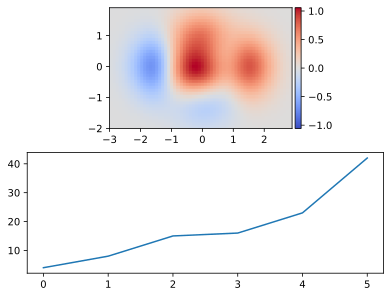

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=2)
im = ax1.imshow(z, extent=extent, vmin=-zmax, vmax=zmax)
add_colorbar(im)
ax2.plot([4, 8, 15, 16, 23, 42]);

Yes, it seems to work (although this very example doesn't look very pleasing).

## Does This Work with Horizontal Color Bars?

I don't know, I didn't try.

## More Stuff

text labels inside the colorbar: http://stackoverflow.com/questions/15908371/matplotlib-colorbars-and-its-text-labels

multiple subplots with colorbars: http://stackoverflow.com/questions/18266642/multiple-imshow-subplots-each-with-colorbar

one colorbar for multiple subplots:
* http://stackoverflow.com/questions/7875688/how-can-i-create-a-standard-colorbar-for-a-series-of-plots-in-python
* http://stackoverflow.com/questions/13784201/matplotlib-2-subplots-1-colorbar

<p xmlns:dct="http://purl.org/dc/terms/">
  <a rel="license"
     href="http://creativecommons.org/publicdomain/zero/1.0/">
    <img src="http://i.creativecommons.org/p/zero/1.0/88x31.png" style="border-style: none;" alt="CC0" />
  </a>
  <br />
  To the extent possible under law,
  <span rel="dct:publisher" resource="[_:publisher]">the person who associated CC0</span>
  with this work has waived all copyright and related or neighboring
  rights to this work.
</p>